In [ ]:
from torchvision.models import *
import pretrainedmodels

from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta

from utils import *
import sys
import site

In [ ]:
#fastai cannot accomodate v3 by default, so you must include this
#see https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb
#for details on including InceptionV3 in fastAI
def forward_inception_v3(self, x):
    x = self.Conv2d_1a_3x3(x)
    x = self.Conv2d_2a_3x3(x)
    x = self.Conv2d_2b_3x3(x)
    x = F.max_pool2d(x, kernel_size=3, stride=2)
    x = self.Conv2d_3b_1x1(x)
    x = self.Conv2d_4a_3x3(x)
    x = F.max_pool2d(x, kernel_size=3, stride=2)
    x = self.Mixed_5b(x)
    x = self.Mixed_5c(x)
    x = self.Mixed_5d(x)
    x = self.Mixed_6a(x)
    x = self.Mixed_6b(x)
    x = self.Mixed_6c(x)        
    x = self.Mixed_6d(x)        
    x = self.Mixed_6e(x)        
    if self.training and self.aux_logits:
        aux = self.AuxLogits(x)
    x = self.Mixed_7a(x)        
    x = self.Mixed_7b(x)        
    x = self.Mixed_7c(x)
    return x

In [ ]:
#fastai monkey patch
Inception3.forward = forward_inception_v3

In [ ]:
#fastai monkey patch
def inception_v3_cut(pretrained=False):    
    model = inception_v3(pretrained)
    return nn.Sequential(model)

In [ ]:
#fastai monkey patch
model_meta[inception_v3_cut] =  { 'cut': noop, 
                                  'split': lambda m: (list(m[0][0].children())[9], m[1]) }

In [ ]:
PATH = "/tf/GP-Labeled-Dataset/"
bs = 16 #batch size

In [ ]:
#extract data from imagenet style directory (with train test valid folders), 
#apply small transforms like rotations, flipping etc to augment the data, 
#resize images to 299x299, and normalize it to imagenet_stats
data = ImageDataBunch.from_folder(PATH, size=299, bs=16, ds_tfms=get_transforms()).normalize(imagenet_stats)

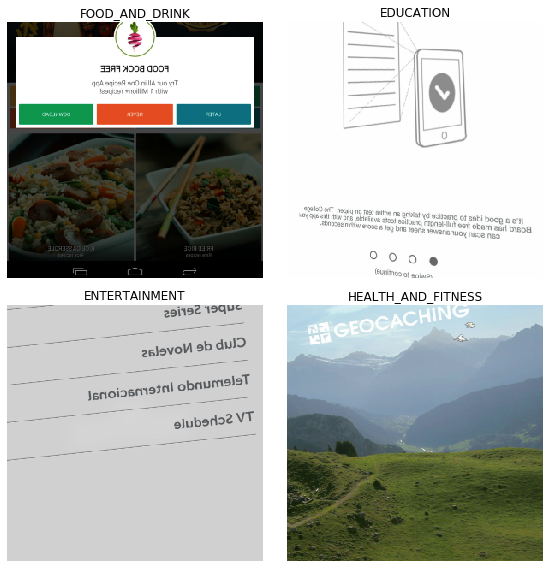

In [ ]:
data.show_batch(rows=2)

In [ ]:
learn = cnn_learner(data, inception_v3_cut, pretrained=True, metrics=error_rate)

In [ ]:
get_groups(nn.Sequential(*learn.model[0][0].children(), *learn.model[1]), learn.layer_groups)

Group 1: ['BasicConv2d', 'BasicConv2d', 'BasicConv2d', 'BasicConv2d', 'BasicConv2d', 'InceptionA', 'InceptionA', 'InceptionA', 'InceptionB']
Group 2: ['InceptionC', 'InceptionC', 'InceptionC', 'InceptionC', 'InceptionAux', 'InceptionD', 'InceptionE', 'InceptionE', 'Linear']
Group 3: ['AdaptiveConcatPool2d', 'Flatten', 'BatchNorm1d', 'Dropout', 'Linear', 'ReLU', 'BatchNorm1d', 'Dropout', 'Linear']


In [ ]:
#8 epochs
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,4.546613,3.880392,0.918651,03:53
1,3.958963,3.693420,0.895833,03:54
2,3.606559,3.375424,0.880952,03:53
3,3.418704,3.263945,0.855159,04:13
4,3.261904,3.199138,0.846230,04:05
5,3.173407,3.160270,0.835317,03:53
6,3.090669,3.116245,0.825397,03:54
7,2.997772,3.108183,0.829365,03:54
